In [1]:
# tensorflow keras 버전 확인합니다.
import tensorflow
tensorflow.keras.__version__

'2.4.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime
import requests
import time
import plotly
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline 

In [ ]:

def get_html(code: str, page: int) -> str:
    url = "https://finance.naver.com/item/sise_day.nhn?"
    querystring = {"code":code, "page":page}
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"}
    response = requests.get(url, params=querystring, headers=headers)
    try:
        response.raise_for_status()
    except Exception as exc:
        print(exc)
        exit(0)
    
    return response.text

def get_last_page(code: str) -> int:
    page = 9999
    dfs = pd.read_html(get_html(code, page))
    df = dfs[1]
    return df[df.shape[1]-1].iloc[0]

def scrap_data(code: str, sleep_time: int=2) -> pd.DataFrame:
    df = pd.DataFrame()
    for page in range(1, get_last_page(code)+1):
        date_converter = lambda d:d.replace('.', '-')
        dfs = pd.read_html(io=get_html(code, page), converters={0:date_converter})
        df = df.append(dfs[0].dropna().astype(dtype='int64', errors='ignore'), ignore_index=True)
        print(df.tail(1))
        time.sleep(sleep_time)
    return df

def store_data(df: pd.DataFrame, code: int) -> None:
    df.to_csv(f"{code}.csv", index=False)

code = '005930' # 삼성전자 종목 코드
store_data(scrap_data(code), code)

In [3]:
data = pd.read_csv('005930.csv') 
data.head()

,날짜,종가,전일비,시가,고가,저가,거래량
0,2021-06-18,80500,400,81100,81100,80500,14618173
1,2021-06-17,80900,900,81100,81300,80700,14007385
2,2021-06-16,81800,900,81500,81900,81100,14999855
3,2021-06-15,80900,400,80900,81200,80600,10075685
4,2021-06-14,80500,500,80800,80900,80500,10550078


In [4]:
data = data.dropna() 

data = data.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 

data['date'] = pd.to_datetime(data['date']) 

data = data.sort_values(by=['date'], ascending=True) 

data.head()

,date,close,diff,open,high,low,volume
6276,1996-06-25,67500,0,66500,68300,65600,112960
6275,1996-06-26,67700,200,67600,67900,66000,136630
6274,1996-06-27,66900,800,67500,67700,66700,155450
6273,1996-06-28,68100,1200,67300,68500,67200,138430
6272,1996-06-29,68500,400,68100,69100,67100,96710


In [5]:
data = data.loc[data['date']>='2018-05-04',]
data.head()

,date,close,diff,open,high,low,volume
768,2018-05-04,51900,1100,53000,53900,51800,39565391
767,2018-05-08,52600,700,52600,53200,51900,23104720
766,2018-05-09,50900,1700,52600,52800,50900,16128305
765,2018-05-10,51600,700,51700,51700,50600,13905263
764,2018-05-11,51300,300,52000,52200,51200,10314997


In [6]:
data.shape

(769, 7)

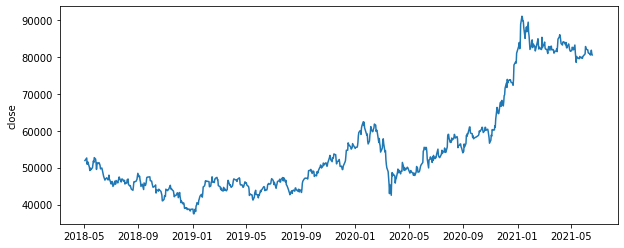

In [7]:
plt.figure(figsize=(10,4))
plt.plot(data['date'], data['close'])
plt.xlabel('')
plt.ylabel('close')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=True,      
    top=False,        
    labelbottom=True) 
plt.show()

In [8]:
high_prices = data['high'].values
low_prices = data['low'].values
mid_prices = (high_prices + low_prices) / 2

In [9]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [10]:
scale = result[0][1]
scale

52550.0

In [11]:
normalized_data = []
for window in result:
    #normalized_window = [((p / window[0]) - 1) for p in window]
    normalized_window = [((p /scale) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((646, 50, 1), (72, 50, 1))

In [12]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(32, return_sequences=True, dropout=0.1))

model.add(LSTM(16, return_sequences=False, dropout=0.1))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [13]:
import numpy as np


class EarlyStoppingAtMinLoss(tensorflow.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [14]:
history=model.fit(x_train, y_train,validation_split=0.2,
    batch_size=10,
    epochs=50)#,callbacks=[EarlyStoppingAtMinLoss()])

Epoch 1/50
52/52 [==============================] - 7s 66ms/step - loss: 0.0099 - val_loss: 0.0032
Epoch 2/50
52/52 [==============================] - 2s 39ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 3/50
52/52 [==============================] - 2s 39ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 4/50
52/52 [==============================] - 2s 39ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 5/50
52/52 [==============================] - 2s 39ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/50
52/52 [==============================] - 2s 40ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 7/50
52/52 [==============================] - 2s 40ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/50
52/52 [==============================] - 2s 40ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/50
52/52 [==============================] - 2s 40ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/50
52/52 [==============================] - 2s 39ms/step - loss: 0.0013 - val_loss: 8.7440e-04
Epoch

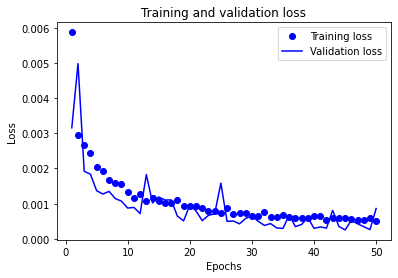

In [15]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

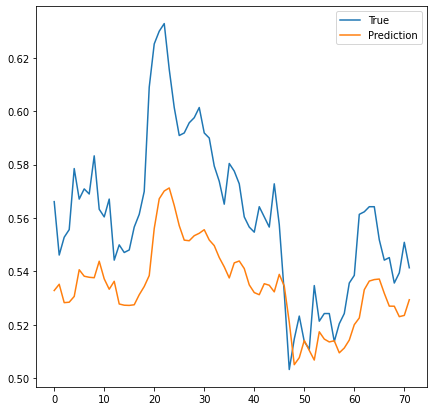

In [16]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

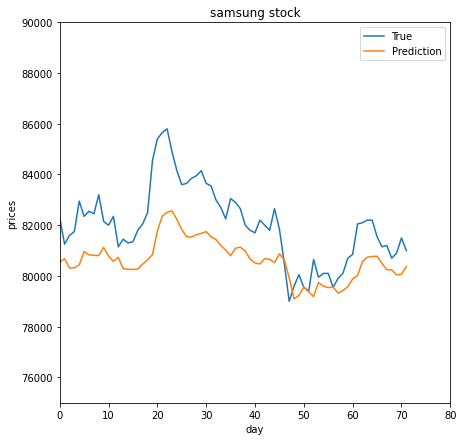

In [17]:
final_price = (pred+1) * scale
true_price = (y_test+1) * scale
fig =plt.figure(facecolor='white',figsize=(7,7))
ax =fig.add_subplot(1,1,1)
ax.set(xlim=[0,80],ylim=[75000,90000],title='samsung stock', xlabel='day',ylabel='prices')
ax.plot(true_price, label='True')
ax.plot(final_price, label='Prediction')
ax.legend()
plt.show()

In [18]:
res = pd.DataFrame(data=true_price)
res.columns=['true']
res['pred'] = final_price
res['diff'] = res['true']-res['pred']
res.head

<bound method NDFrame.head of        true          pred         diff
0   82300.0  80552.484375  1747.515625
1   81250.0  80675.531250   574.468750
2   81600.0  80314.171875  1285.828125
3   81750.0  80322.968750  1427.031250
4   82950.0  80436.328125  2513.671875
..      ...           ...          ...
67  81200.0  80245.554688   954.445312
68  80700.0  80243.937500   456.062500
69  80900.0  80038.945312   861.054688
70  81500.0  80063.140625  1436.859375
71  81000.0  80371.109375   628.890625

[72 rows x 3 columns]>

In [19]:
df = data
df = data.rename(columns= {'date': 'Date', 'close': 'Close', 'open': 'Open', 'high': 'High', 'low': 'Low', 'volume': 'Volume'}) 
df.index=df.index.sort_values(ascending=True)
df.head

<bound method NDFrame.head of           Date  Close  diff   Open   High    Low    Volume
0   2018-05-04  51900  1100  53000  53900  51800  39565391
1   2018-05-08  52600   700  52600  53200  51900  23104720
2   2018-05-09  50900  1700  52600  52800  50900  16128305
3   2018-05-10  51600   700  51700  51700  50600  13905263
4   2018-05-11  51300   300  52000  52200  51200  10314997
..         ...    ...   ...    ...    ...    ...       ...
764 2021-06-14  80500   500  80800  80900  80500  10550078
765 2021-06-15  80900   400  80900  81200  80600  10075685
766 2021-06-16  81800   900  81500  81900  81100  14999855
767 2021-06-17  80900   900  81100  81300  80700  14007385
768 2021-06-18  80500   400  81100  81100  80500  14618173

[769 rows x 7 columns]>

In [20]:
#short_window = int(0.025 * len(df))
#long_window = int(0.05 * len(df))

short_window = 5
long_window = 66

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,51900.0,51900.000000,NaN
1,0.0,52250.0,52250.000000,0.0
2,0.0,51800.0,51800.000000,0.0
3,0.0,51750.0,51750.000000,0.0
4,0.0,51660.0,51660.000000,0.0
...,...,...,...,...
764,0.0,81100.0,81996.969697,0.0
765,0.0,80900.0,81980.303030,0.0
766,0.0,81040.0,81965.151515,0.0
767,0.0,81020.0,81951.515152,0.0


In [21]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 100000,
    max_buy = 2,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 100000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - short_window):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [22]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 13: buy 1 units at price 52700.000000, total balance 47300.000000
day 19, sell 1 units at price 51100.000000, investment -3.036053 %, total balance 98400.000000,
day 21: buy 1 units at price 50600.000000, total balance 47800.000000
day 22, sell 1 units at price 49650.000000, investment -1.877470 %, total balance 97450.000000,
day 80: buy 2 units at price 96900.000000, total balance 550.000000
day 85, sell 1 units at price 44900.000000, investment -7.327141 %, total balance 45450.000000,
day 95: total balances 45450.000000, not enough money to buy a unit price 47400.000000
day 101, sell 1 units at price 44700.000000, investment -5.696203 %, total balance 90150.000000,
day 173: buy 2 units at price 85500.000000, total balance 4650.000000
day 236, sell 1 units at price 44750.000000, investment 4.678363 %, total balance 49400.000000,
day 274: buy 1 units at price 45500.000000, total balance 3900.000000
day 307, sell 1 units at price 43500.000000, investment -4.395604 %, total balance 4

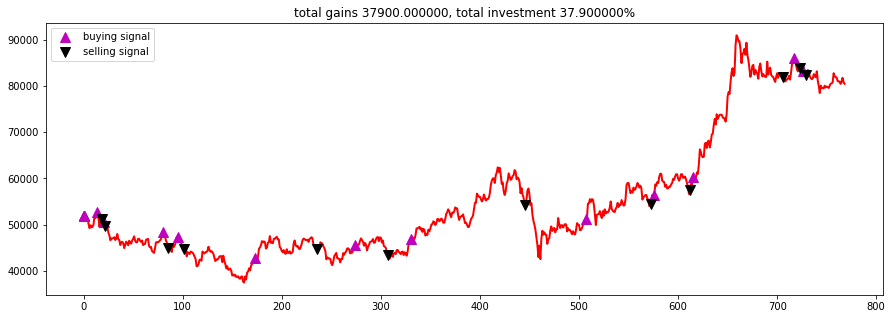

In [23]:

close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()